In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Reader():

    def __init__(self, file_name):
        self.file_name = file_name
        self.nparticles = 14
        self.timestep, self.runsteps, self.log_frequency = self.get_metadata()
        self.n_logged_timesteps = int(self.runsteps/self.log_frequency + 1)
        self.logged_timesteps = np.arange(0, self.runsteps+1, self.log_frequency)
    
    def read_original_traj(self, save=True):
        subfix = '-traj.dump'
        lines = []
        with open(self.file_name+subfix, 'r') as f:
            particles_counter = 0
            particles_temp = []
            log_count = 0
            for i, line in enumerate(f):   
                if particles_counter == self.nparticles:
                    particles_temp = np.array(particles_temp, dtype=float)
                    particles_temp = particles_temp[particles_temp[:, 2].argsort()]
                    lines.append(particles_temp)
                    particles_counter = 0
                    particles_temp = []
                    log_count += 1
                    continue
                elif particles_counter > 0:
                    line = line.rstrip(' \n')
                    line = line.split()
                    line.pop(1) # remove 'type' column
                    particles_temp.append([str(self.logged_timesteps[log_count]), self.body_id(line[0])]+line)
                    particles_counter += 1
                else:
                    if i == 8:
                        line = line.lstrip('ITEM: ATOMS ')
                        labels = line.split()
                        labels.remove('type')
                        labels = ['timestep', 'body_id'] + labels
                    if (i-9) % 23 == 0:
                        line = line.rstrip(' \n')
                        line = line.split()
                        line.pop(1) # remove 'type' column
                        particles_temp.append([str(self.logged_timesteps[log_count]), self.body_id(line[0])]+line)
                        particles_counter += 1
        
        lines = np.vstack(lines)
        if save:
            df = pd.DataFrame(lines, columns=labels)
            df.to_csv(self.file_name+'-original_traj.csv', index=False)
            
        return labels, lines

    def read_reduced_traj(self, save=True):
        subfix = '-info.dat'
        lines = []
        log_count = 0
        with open(self.file_name+subfix, 'r') as f:
            for i, line in enumerate(f):
                if i == 8:
                    line = line.lstrip('ITEM: ENTRIES ')
                    labels = ['timestep'] + line.split()
                if (i+1) % 10 == 0:
                    line = line.rstrip(' \n')
                    line = [str(self.logged_timesteps[log_count])] + line.split()
                    lines.append(line)
                    log_count += 1
        lines = np.array(lines, dtype=float)

        # TODO: add a column for body_id rather than have so many columns
        if save:
            df = pd.DataFrame(lines, columns=labels)
            df.to_csv(self.file_name+'-reduced_traj.csv', index=False)
        
        return labels, lines

    def read_simulation_log(self):
        # TODO: is this useful for anything? make this useful
        # FIX: it does not even work
        subfix = '-sim.log'
        lines = np.zeros([])
        with open(self.file_name+subfix, 'r') as f:
            for i, line in enumerate(f):
                if i < 64:
                    continue
                if i == 64:
                    label = line.split()
                    lines = np.zeros([self.n_logged_timesteps, len(label)])
                    step_no = 0
                else:
                    line = line.rstrip(' \n')
                    line = line.split()
                    try:
                        line = np.array(line, dtype=float)
                    except ValueError:
                        print(f"Breaking - likely reached last line of sim log: {line}")
                        break
                    lines[step_no] = line
                    step_no += 1
        
        return label, lines

    def get_metadata(self):
        subfix = '-input.log'
        with open(self.file_name+subfix, 'r') as f:
            counter = 0
            for i, line in enumerate(f):
                if line == '\n':
                    continue
                else:
                    counter += 1
                    if counter == 2:
                        log_frequency = int(line.split()[3])
                    elif counter == 3:
                        runsteps = int(line.split()[3])
                    elif counter == 4:
                        timestep = float(line.split()[3])
                        break

        print(f"Found timestep: {timestep}, n of run steps: {runsteps}, and dump log freq: {log_frequency}")
        return timestep, runsteps, log_frequency

    def body_id(self, atom_id):
        if (int(atom_id)) <= (self.nparticles // 2):
            return 1
        else:
            return 2 

In [75]:
# Read files
K = 0.01
R0 = 3
T = 0.2
SEED = 5
# file_name = f'NVE-temp-{T}_K-{K}_r-{R0}_s-{SEED}'
# prefix = 'hexagons/trajectories/dump_2303/'
# file_name = prefix+'NVE-temp-0.2_K-0.493827160493827_r-0_s-5'
prefix = 'hexagons/trajectories/inertia_issue/'
file_name = prefix+'NVE-temp-0.45_K-0.219478737997257_r-0_s-5'

reader = Reader(file_name)
# log_labels, log_lines = reader.read_simulation_log()
traj_labels, traj_lines = reader.read_reduced_traj(save=True)
orig_labels, orig_lines = reader.read_original_traj(save=True)

Found timestep: 1e-06, n of run steps: 10000000, and dump log freq: 100


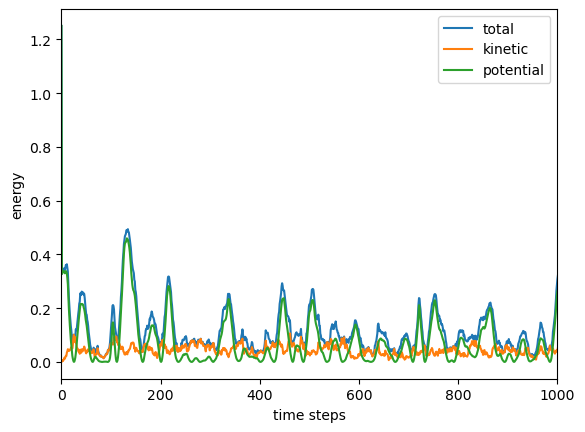

In [2]:
kineticEnergy = log_lines[:, -2]
forceMagnitude = log_lines[:, 4]

# x_diff = traj_lines[:, 0] - traj_lines[:, 3]
# y_diff = traj_lines[:, 1] - traj_lines[:, 4]
# z_diff = traj_lines[:, 2] - traj_lines[:, 5]
# com_distance = np.sqrt(x_diff**2 + y_diff**2 + z_diff**2)

k = 0.1
r0 = 5.0 
com_distance = np.linalg.norm(traj_lines[:, 0:3] - traj_lines[:, 3:6], axis=1)
potentialEnergy = 0.5 * k * (com_distance - r0)**2
# is this the correct way to calculate all of this?

totalEnergy = kineticEnergy + potentialEnergy

# print(com_distance[2])
# print(totalEnergy.shape)
# print(potentialEnergy.shape)

plt.plot(totalEnergy, label='total')
plt.plot(kineticEnergy, label='kinetic')
plt.plot(potentialEnergy, label='potential')
plt.xlabel('time steps')
plt.ylabel('energy')
plt.legend()
plt.xlim(0, 1000)
# plt.ylim(0, 0.2)
plt.show()


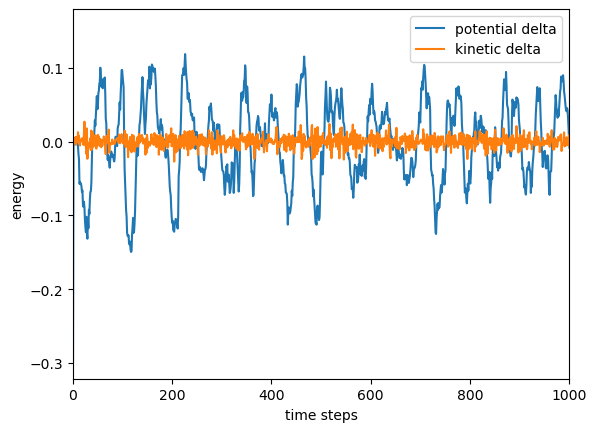

In [3]:
deltaPotential = - k / 2 * (com_distance[1:]**2 - com_distance[:-1]**2)
deltaKinetic = kineticEnergy[1:] - kineticEnergy[:-1]

plt.plot(deltaPotential, label='potential delta')
plt.plot(deltaKinetic, label='kinetic delta')
plt.xlim(0, 1000)
plt.xlabel('time steps')
plt.ylabel('energy')
plt.legend()
plt.show()

In [138]:
print(log_lines[:20, 4])
q = np.sqrt(log_lines[:20, 1]**2 + log_lines[:20, 2]**2 + log_lines[:20, 3]**2) 
print(q)

[-0.01821793 -0.01826263 -0.01840154 -0.01851226 -0.01856435 -0.01855492
 -0.01844083 -0.01834017 -0.01847531 -0.01856517 -0.01849526 -0.01831862
 -0.0178325  -0.01717194 -0.0156663  -0.01432805 -0.01300073 -0.01175871
 -0.01050121 -0.00915952]
[0.01821793 0.01826263 0.01840154 0.01851226 0.01856435 0.01855492
 0.01844083 0.01834017 0.01847531 0.01856516 0.01849526 0.01831862
 0.0178325  0.01717194 0.0156663  0.01432805 0.01300073 0.01175871
 0.01050121 0.00915952]


In [139]:
kineticEnergy = log_lines[:, -2]
forceMagnitude = log_lines[:, 4]

def moving_average(x, w=50):
    return np.convolve(x, np.ones(w), 'valid') / w

# x_diff = traj_lines[:, 0] - traj_lines[:, 3]
# y_diff = traj_lines[:, 1] - traj_lines[:, 4]
# z_diff = traj_lines[:, 2] - traj_lines[:, 5]
# com_distance = np.sqrt(x_diff**2 + y_diff**2 + z_diff**2)

com_distance = np.linalg.norm(traj_lines[:, 0:3] - traj_lines[:, 3:6], axis=1)
potentialEnergy = - 0.5 * K * (com_distance**2 - R0**2)
# is this the correct way to calculate all of this? yes, I believe so

totalEnergy = log_lines[:,-1]
totalReducedEnergy = totalEnergy - potentialEnergy

plt.figure(facecolor='white')
plt.title(f"K = {K} and T = {T}")
plt.plot(moving_average(totalEnergy), label='total logged energy')
plt.plot(moving_average(totalReducedEnergy), label='total + harmonic potential)')
# plt.plot(kineticEnergy, label='kinetic (total logged energy)')
# plt.plot(potentialEnergy, label='calculated harmonic potential')
plt.xlabel('time steps')
plt.ylabel('energy')
plt.legend()
plt.show()

# DELTA PLOT

# deltaPotential = - K / 2 * (com_distance[1:]**2 - com_distance[:-1]**2)
deltaReduced = totalReducedEnergy[1:] - totalReducedEnergy[:-1]
deltaEnergy = totalEnergy[1:] - totalEnergy[:-1]

plt.figure(facecolor='white')
plt.plot(moving_average(deltaEnergy), label='Total Energy Change')
plt.plot(moving_average(deltaReduced), label='Total Energy (+ harmonic) Change')
plt.xlabel('Time Steps')
plt.ylabel('Energy Change')
plt.legend()
plt.show()

array([3.31892990e-04, 3.33523721e-04, 3.38616684e-04, 3.42703882e-04,
       3.44635165e-04, 3.44285009e-04, 3.40064351e-04, 3.36361735e-04,
       3.41337040e-04, 3.44665340e-04, 3.42074609e-04, 3.35571667e-04,
       3.17998077e-04, 2.94875580e-04, 2.45433062e-04, 2.05293145e-04,
       1.69019072e-04, 1.38267288e-04, 1.10275447e-04, 8.38967935e-05])

Found timestep: 1e-05, n of run steps: 1000000, and dump log freq: 1000
torch.Size([1, 1001, 2, 3])


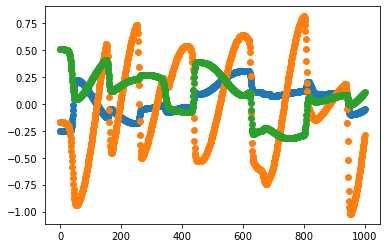

In [22]:
from data.trajectory import Trajectory
import matplotlib.pyplot as plt


traj = Trajectory('hexagons/trajectories/jakub/NVE-temp-2.25_K-17.8583270116258_r-2_s-5', 'cpu')

vel = traj.traj[0]
print(vel.shape)
plt.plot(vel[0, :, 0, :], 'o')
plt.show()

Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 1000
Breaking - likely reached last line of sim log: ['Loop', 'time', 'of', '219.559', 'on', '1', 'procs', 'for', '100000000', 'steps', 'with', '14', 'atoms']


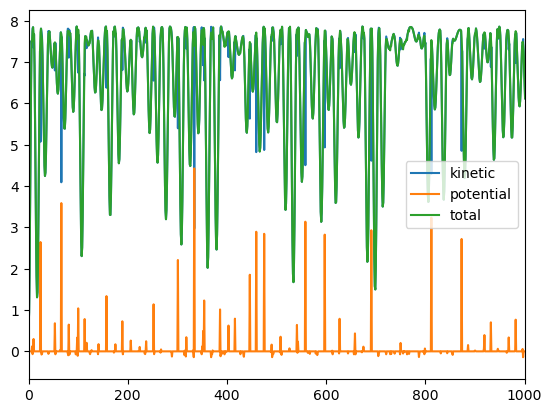

In [17]:
from data.reader import Reader
import matplotlib.pyplot as plt
import numpy as np

reader = Reader('dataset/trajectories/jakub/NVE-temp-2.25_K-17.8583270116258_r-2_s-5')

def moving_average(x, w=50):
    return np.convolve(x, np.ones(w), 'valid') / w

# print(reader.read_simulation_log()[0])
data_label, data_lines = reader.read_simulation_log()

def harmonic_energy():
    k = 17.8583270116258
    r0 = 2.0
    com_distance = data_lines[:, 4]
    return 0.5 * k * (com_distance - r0)**2

plt.plot(data_lines[:, -2], label='kinetic')
plt.plot(data_lines[:, -3], label='potential')
plt.plot(data_lines[:, -1], label='total')
# plt.plot(harmonic_energy(), label='harmonic')
plt.legend()
plt.xlim(0, 1000)
plt.show()

Index(['timestep', 'c_com_1[1]', 'c_com_1[2]', 'c_com_1[3]', 'c_com_2[1]',
       'c_com_2[2]', 'c_com_2[3]', 'c_vel_1[1]', 'c_vel_1[2]', 'c_vel_1[3]',
       'c_vel_2[1]', 'c_vel_2[2]', 'c_vel_2[3]', 'c_q_1[1]', 'c_q_1[2]',
       'c_q_1[3]', 'c_q_1[4]', 'c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]', 'c_q_2[4]',
       'c_av_1[1]', 'c_av_1[2]', 'c_av_1[3]', 'c_av_2[1]', 'c_av_2[2]',
       'c_av_2[3]', 'c_am_1[1]', 'c_am_1[2]', 'c_am_1[3]', 'c_am_2[1]',
       'c_am_2[2]', 'c_am_2[3]', 'c_i_1[1]', 'c_i_1[2]', 'c_i_1[3]',
       'c_i_2[1]', 'c_i_2[2]', 'c_i_2[3]'],
      dtype='object')
(10001, 39)
(10001, 3)


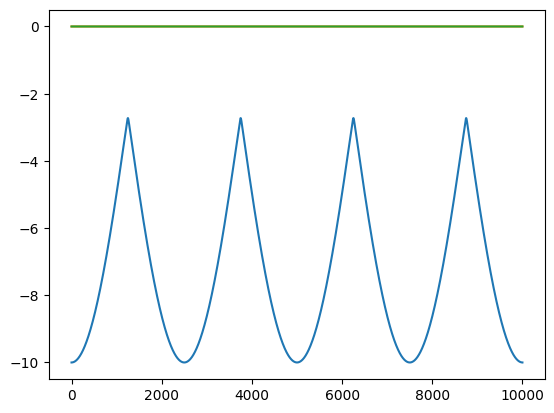

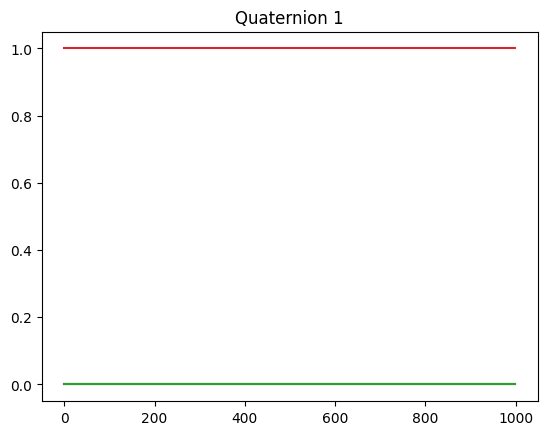

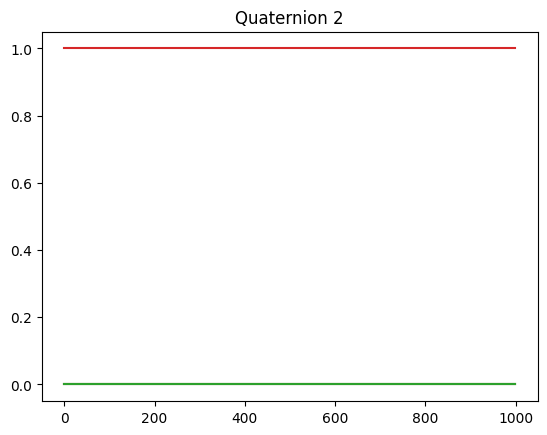

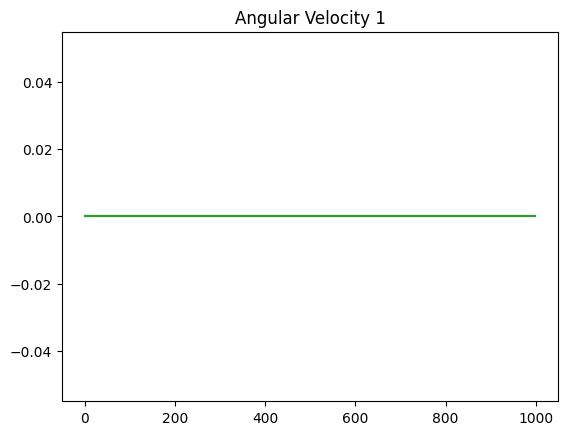

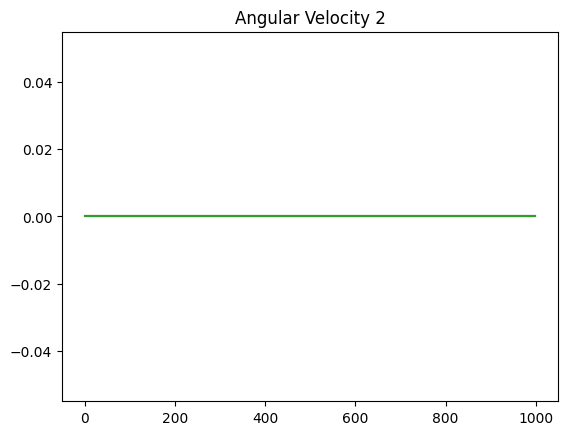

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from data.reader import Reader
# reader = Reader('dataset/trajectories/thesis/NVE-temp-0.5_K-3.96851711369462_r-2_s-5')
# _, _ = reader.read_reduced_traj(save=True)
df = pd.read_csv('dataset/approach/test/NVE-temp-0.5_K-3.96851711369462_r-2_s-20-reduced_traj.csv')
# df = pd.read_csv('dataset/smooth/NVE-temp-0.45_K-0.090702947845805_r-0_s-5-reduced_traj.csv')

print(df.columns)
# get centre of mass position and velocity
com_pos = df.iloc[:, 1:7].values
# com_vel = df.iloc[:, 7:7+6].values

print(df.to_numpy().shape)

quats = df.loc[:, ['c_q_1[1]', 'c_q_1[2]',
       'c_q_1[3]', 'c_q_1[4]', 'c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]', 'c_q_2[4]']].values

angvels = df.loc[:, ['c_av_1[1]', 'c_av_1[2]', 'c_av_1[3]', 'c_av_2[1]', 'c_av_2[2]', 'c_av_2[3]']].values

# print(com_pos)
# print(com_vel)

# separation vector
sep = com_pos[:, 0:3] - com_pos[:, 3:6]
plt.plot(sep[:, 0])
plt.plot(sep[:, 1])
plt.plot(sep[:, 2])

print(sep.shape)


plt.show()
end_index = quats.shape[0] // 10
plt.title('Quaternion 1')
plt.plot(quats[:end_index, 0])
plt.plot(quats[:end_index, 1])
plt.plot(quats[:end_index, 2])
plt.plot(quats[:end_index, 3])
plt.show()


plt.title('Quaternion 2')
plt.plot(quats[:end_index, 4])
plt.plot(quats[:end_index, 5])
plt.plot(quats[:end_index, 6])
plt.plot(quats[:end_index, 7])
plt.show()

plt.title('Angular Velocity 1')
plt.plot(angvels[:end_index, 0])
plt.plot(angvels[:end_index, 1])
plt.plot(angvels[:end_index, 2])
plt.show()

plt.title('Angular Velocity 2')
plt.plot(angvels[:end_index, 3])
plt.plot(angvels[:end_index, 4])
plt.plot(angvels[:end_index, 5])
plt.show()




In [32]:
import torch
torch.cuda.empty_cache()
from diffmd.training import Trainer
import numpy as np


config = dict(
    # folder = 'dataset/approach',
    # folder = 'dataset/oscillation',
    folder = 'dataset/archive/single_temp_overfit_new', 
    device = torch.device('cpu'), 
    epochs = 100,
    start_epoch = 0,
    optimizer = 'Adam',
    batch_length=40,
    batch_size=10000,
    shuffle=True,
    num_workers=0,
    learning_rate=10**(-2.677258979840062),
    nn_widths=[9*8, 6*8, 1*8],
    activation_function='tanh',
    eval_batch_length=100,
    load_folder='results/2022-08-08/17-01-19',
    dtype=torch.float32,
    itr_printing_freq=1,
    printing_freq=1,
    plotting_freq=1,
    stopping_freq=5,
    stopping_look_back=3,
    scheduler='LambdaLR',
    scheduling_factor=0.95,
    scheduling_freq=10,
    evaluation_freq=5,
    checkpoint_freq=5,
    loss_func = 'final',
    sigopt=True,
    )

trainer = Trainer(config)

# trainer.save()

# print(trainer.evaluate(validate=True))



Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001


RuntimeError: Error(s) in loading state_dict for ODEFunc:
	Unexpected key(s) in state_dict: "net.6.weight", "net.6.bias". 
	size mismatch for net.0.weight: copying a param with shape torch.Size([72, 11]) from checkpoint, the shape in current model is torch.Size([80, 11]).
	size mismatch for net.0.bias: copying a param with shape torch.Size([72]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for net.2.weight: copying a param with shape torch.Size([48, 72]) from checkpoint, the shape in current model is torch.Size([8, 80]).
	size mismatch for net.2.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for net.4.weight: copying a param with shape torch.Size([8, 48]) from checkpoint, the shape in current model is torch.Size([1, 8]).
	size mismatch for net.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([1]).

In [4]:
print(trainer.evaluate(True))

0.011311589615534365


In [2]:
trainer.plot_traj(0, 'results/depth-2-width-1000-lr-0.02-loss-all/47000')

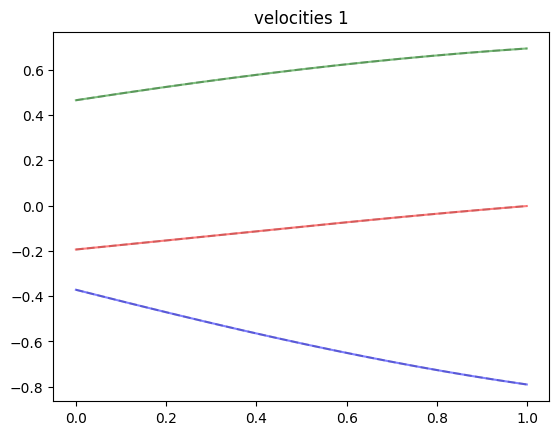

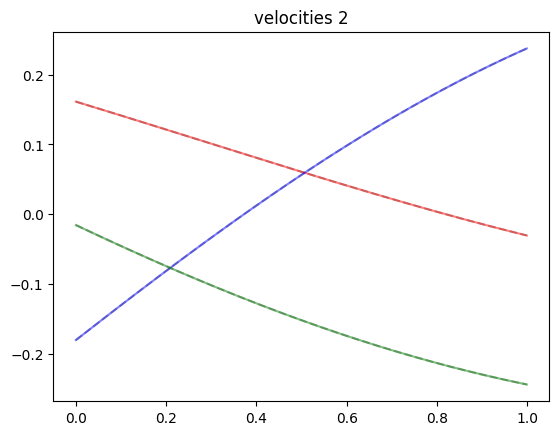

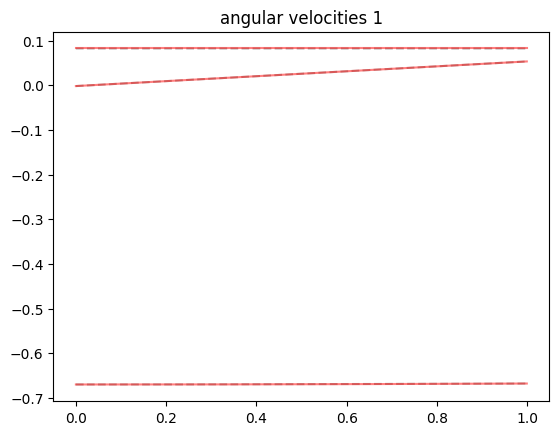

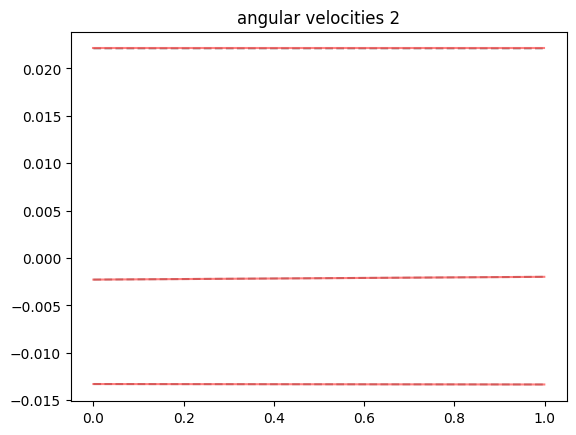

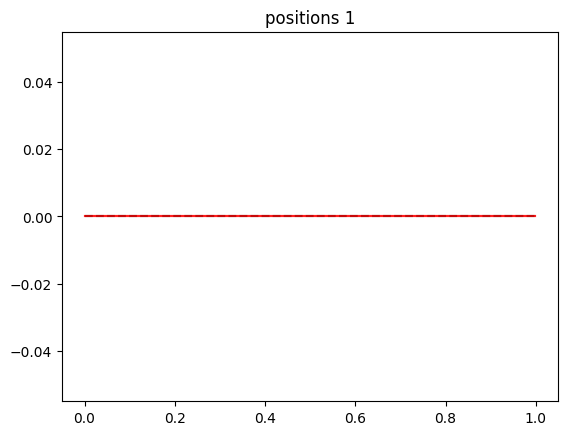

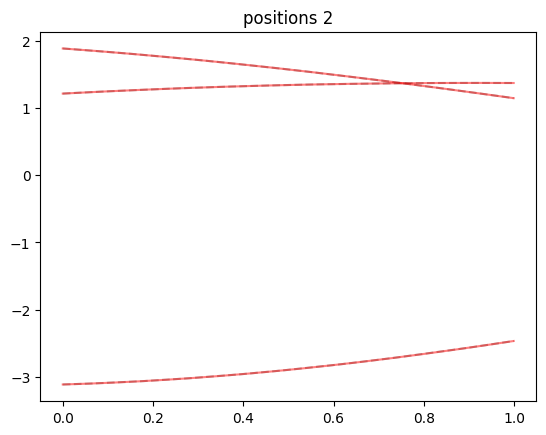

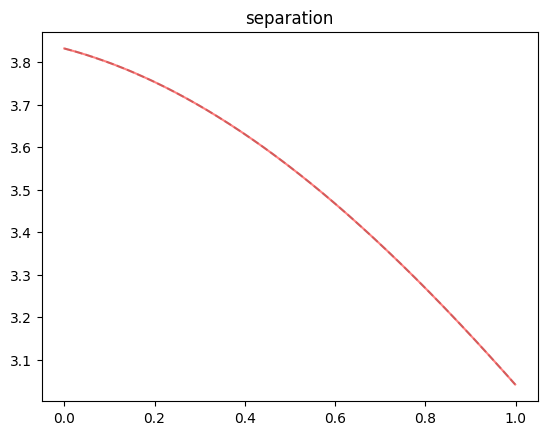

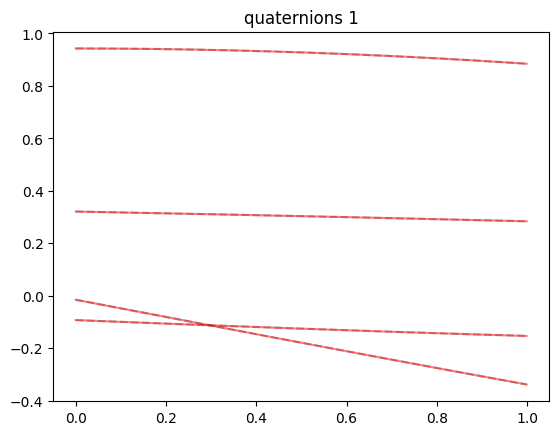

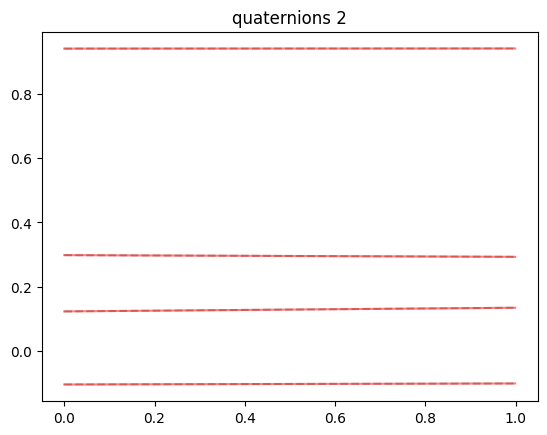

In [22]:
from diffmd.solvers import odeint_adjoint
import matplotlib.pyplot as plt
with torch.no_grad():
    traj_length = 1000
    nbatches = 1
    start_index = 0
    
    with torch.no_grad():
        trainer.training_dataset.batch_length = traj_length
        batch_input, batch_y = trainer.training_dataset[start_index]
        batch_input = list(batch_input)
        batch_input[0] = batch_input[0].unsqueeze(0)
        batch_input = tuple(batch_input)
        
        pred_y = trainer.forward_pass(batch_input, batch_length=traj_length).squeeze().cpu().numpy()
        batch_y = batch_y.cpu().numpy()
        batch_t = trainer.get_batch_t(batch_input[1], batch_length=traj_length).cpu().numpy()
        
        ind_vel = [0, 1, 2]
        ind_ang = [3, 4, 5]
        ind_pos = [6, 7, 8]
        ind_quat = [9, 10, 11, 12]
        colours = ['r-', 'b-', 'g-']
        
        # final error in velocities
        vel_1_err = pred_y[-1, 0, ind_vel] - batch_y[-1, 0, ind_vel]
        vel_2_err = pred_y[-1, 1, ind_vel] - batch_y[-1, 1, ind_vel]
        # print(vel_1_err)
        # print(vel_2_err)


        for c, i in enumerate(ind_vel):
            plt.title('velocities 1')
            plt.plot(batch_t, batch_y[:,0,i], 'k--', alpha=0.3, label=f'true {i}')
            plt.plot(batch_t, pred_y[:,0,i], colours[c], alpha=0.5, label=f'pred {i}')
        plt.savefig('figures/vel1.png')
        plt.show()
        
        for c, i in enumerate(ind_vel):
            plt.title('velocities 2')
            plt.plot(batch_t, batch_y[:,1,i], 'k--', alpha=0.3, label=f'true {i}')
            plt.plot(batch_t, pred_y[:,1,i], colours[c], alpha=0.5, label=f'pred {i}')
        plt.savefig('figures/vel2.png')
        plt.show()
        
        for i in ind_ang:
            plt.title('angular velocities 1')
            plt.plot(batch_t, batch_y[:,0,i], 'k--', alpha=0.3, label=f'true {i}')
            plt.plot(batch_t, pred_y[:,0,i], 'r-', alpha=0.5, label=f'pred {i}')
        plt.savefig('figures/ang_vel1.png')
        plt.show()
        
        for i in ind_ang:
            plt.title('angular velocities 2')
            plt.plot(batch_t, batch_y[:,1,i], 'k--', alpha=0.3, label=f'true {i}')
            plt.plot(batch_t, pred_y[:,1,i], 'r-', alpha=0.5, label=f'pred {i}')
        plt.savefig('figures/ang_vel2.png')
        plt.show()
        
        # centre of mass positions (set initial position of first COM to zero)
        batch_y[:,:,6:9] = batch_y[:,:,6:9] - batch_y[:,[0],6:9]
        pred_y[:,:,6:9] = pred_y[:,:,6:9] - pred_y[:,[0],6:9]
            
        for i in ind_pos:
            plt.title('positions 1')
            plt.plot(batch_t, batch_y[:,0,i], 'k--', alpha=0.3, label=f'true {i}')
            plt.plot(batch_t, pred_y[:,0,i], 'r-', alpha=0.5, label=f'pred {i}')
        plt.show()
        
        for i in ind_pos:
            plt.title('positions 2')
            plt.plot(batch_t, batch_y[:,1,i], 'k--', alpha=0.3, label=f'true {i}')
            plt.plot(batch_t, pred_y[:,1,i], 'r-', alpha=0.5, label=f'pred {i}')
        plt.show()
        
        # centre of mass separation
        batch_y_sep = np.linalg.norm(batch_y[:,1,6:9] - batch_y[:,0,6:9], axis=-1)
        pred_y_sep = np.linalg.norm(pred_y[:,1,6:9] - pred_y[:,0,6:9], axis=-1)

        plt.title('separation')
        plt.plot(batch_t, batch_y_sep, 'k--', alpha=0.3, label=f'true')
        plt.plot(batch_t, pred_y_sep, 'r-', alpha=0.5, label=f'pred')
        plt.savefig('figures/sep.png')
        plt.show()
        
        # quaternions
        for i in ind_quat:
            plt.title('quaternions 1')
            plt.plot(batch_t, batch_y[:,0,i], 'k--', alpha=0.3, label=f'true {i}')
            plt.plot(batch_t, pred_y[:,0,i], 'r-', alpha=0.5, label=f'pred {i}')
        plt.savefig('figures/quat1.png')
        plt.show()
        
        for i in ind_quat:
            plt.title('quaternions 2')
            plt.plot(batch_t, batch_y[:,1,i], 'k--', alpha=0.3, label=f'true {i}')
            plt.plot(batch_t, pred_y[:,1,i], 'r-', alpha=0.5, label=f'pred {i}')
        plt.savefig('figures/quat2.png')
        plt.show()
        

In [4]:
# predicted force
v = pred_y[:31, 0, [0, 1, 2]]
# find difference between succesive rows
dv = np.diff(v, axis=0)
dv_dt = dv / 0.001
f = dv_dt / 7.0
print(f)


# dataset force
v = batch_y[:30, 0, [0, 1, 2]]
# find difference between succesive rows
dv = np.diff(v, axis=0)
dv_dt = dv / 0.001
f = dv_dt / 7.0
print(f)

sep = np.linalg.norm(batch_y[:,1,6:9] - batch_y[:,0,6:9], axis=-1)
r0 = 0
f = - 3.96851711369462 * (sep - r0)
print(f)



[[8.0990225e-01 7.1366691e-07 3.6799756e-07]
 [8.0990040e-01 7.1366605e-07 3.6799716e-07]
 [8.0989724e-01 7.1366441e-07 3.6799628e-07]
 [8.0989349e-01 7.1366196e-07 3.6799489e-07]
 [8.0988872e-01 7.1365838e-07 3.6799312e-07]
 [8.0988282e-01 7.1365412e-07 3.6799082e-07]
 [8.0987644e-01 7.1364985e-07 3.6798880e-07]
 [8.0986899e-01 7.1364371e-07 3.6798627e-07]
 [8.0986053e-01 7.1363655e-07 3.6798320e-07]
 [8.0985087e-01 7.1362950e-07 3.6797942e-07]
 [8.0983973e-01 7.1362035e-07 3.6797510e-07]
 [8.0982912e-01 7.1361222e-07 3.6797078e-07]
 [8.0981737e-01 7.1360211e-07 3.6796624e-07]
 [8.0980355e-01 7.1359193e-07 3.6796112e-07]
 [8.0978972e-01 7.1358079e-07 3.6795504e-07]
 [8.0977482e-01 7.1356862e-07 3.6794947e-07]
 [8.0975884e-01 7.1355441e-07 3.6794336e-07]
 [8.0974293e-01 7.1354123e-07 3.6793628e-07]
 [8.0972481e-01 7.1352696e-07 3.6792918e-07]
 [8.0970669e-01 7.1351076e-07 3.6792105e-07]
 [8.0968648e-01 7.1349450e-07 3.6791292e-07]
 [8.0966520e-01 7.1347523e-07 3.6790379e-07]
 [8.096460

# Is it learning anything?

In [ ]:
# look at a single trajectory across all checkpoints and see whether it is learnign anything

# Potential Energy Landscape

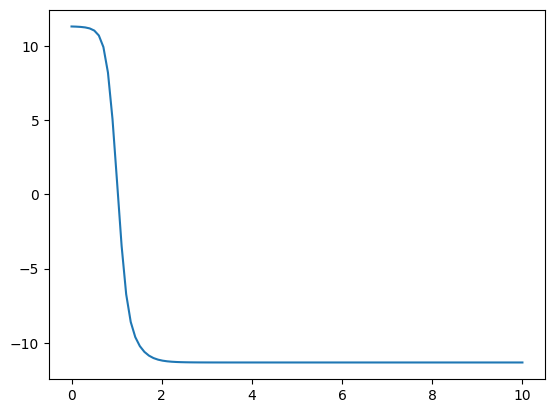

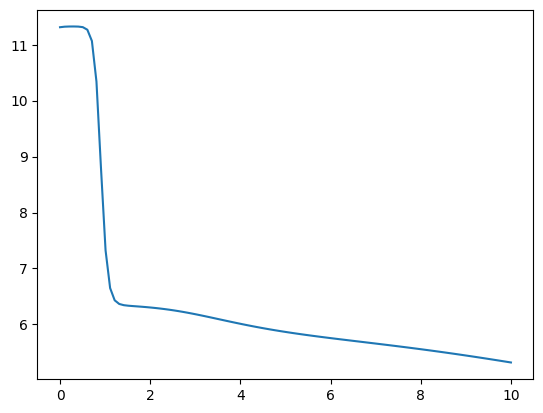

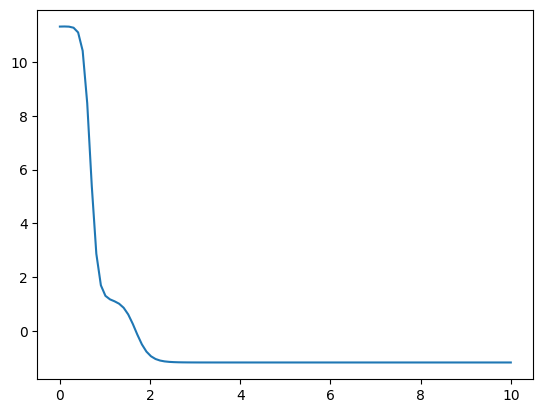

<Figure size 640x480 with 0 Axes>

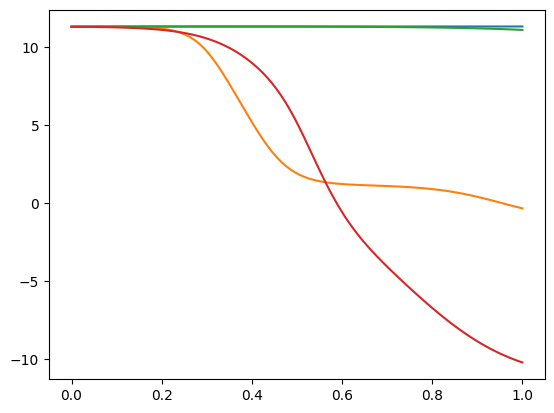

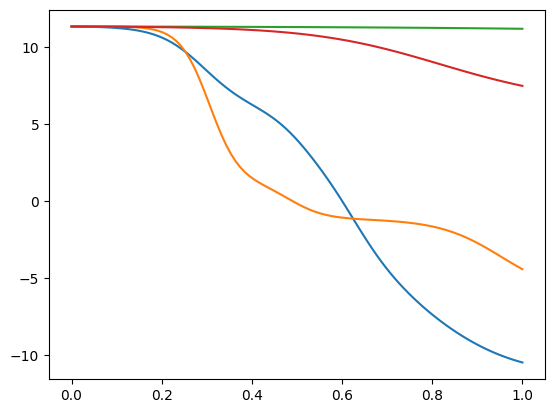

In [30]:
# What does the energy landscape look like? Is there a repulsion?
import torch
import matplotlib.pyplot as plt

inp = torch.zeros(11).to('cpu')

for i in [0, 1, 2]:
    x_1 = torch.linspace(0, 10, 100).to('cpu')
    data = []
    for x in x_1:
        temp = inp.clone()
        temp[i] = x
        data.append(trainer.func.net(temp).item())
    plt.plot(x_1.detach().numpy(), data)
    plt.show()

plt.savefig('output_1.png')
plt.show()


for i in [3, 4, 5, 6]:
    x_1 = torch.linspace(0, 1, 100).to('cpu')
    data = []
    for x in x_1:
        temp = inp.clone()
        temp[i] = x
        data.append(trainer.func.net(temp).item())
    plt.plot(x_1.detach().numpy(), data)

plt.savefig('output_2.png')
plt.show()



for i in [7, 8, 9, 10]:
    x_1 = torch.linspace(0, 1, 100).to('cpu')
    data = []
    for x in x_1:
        temp = inp.clone()
        temp[i] = x
        data.append(trainer.func.net(temp).item())
    plt.plot(x_1.detach().numpy(), data)

plt.savefig('output_3.png')
plt.show()

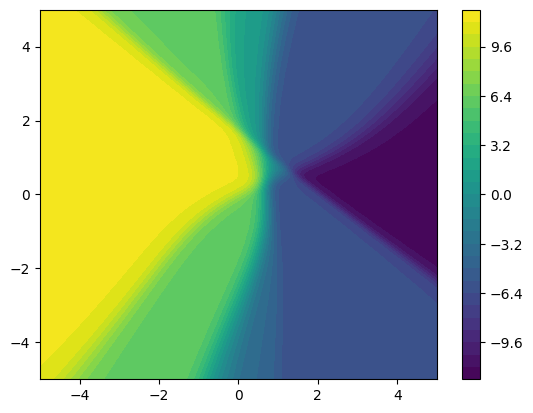

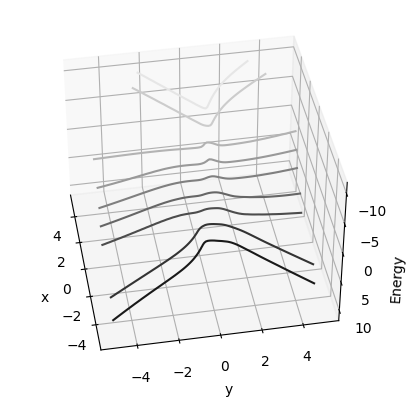

In [31]:
import matplotlib.pyplot as plt
# contour potential
potential = trainer.func.net

start, stop, n_values = -5, 5, 100
vals = np.linspace(start, stop, n_values)

# model
X, Y = np.meshgrid(vals, vals)
XY = np.stack([X, Y], axis=2)

Z = np.zeros((n_values, n_values))

for i in range(XY.shape[0]):
    for j in range(XY.shape[1]):
        inp = np.hstack((XY[i, j], np.array([0, 1, 0, 0, 0, 1, 0, 0, 0])))
        Z[i, j] = potential(torch.Tensor(inp)).detach().cpu().item()
# Z -= Z.min()
plt.contourf(X, Y, Z, levels=30, cmap='viridis')
plt.colorbar()
plt.show()

from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 10, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Energy')
ax.view_init(-140, 10)
plt.show()

import plotly.graph_objects as go


fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

### Playground - Testing DataLoaders

In [1]:
from data.dataset import Dataset
import torch
config = dict(
    folder = 'dataset/dataloader_implementation', 
    device = torch.device("cpu"), 
    niters = 100000,
    start_niter = 0,
    optimizer = 'Adam',
    batch_length=20,
    nbatches=600,
    learning_rate=0.035,
    nn_depth=2,
    nn_width=1000,
    activation_function=None,
    load_folder='results/2022-06-20_17-22-06/',
    # load_folder=None,
    dtype=torch.float32,
    printing_freq=200,
    plotting_freq=500,
    stopping_freq=10000,
    scheduler='LambdaLR',
    scheduling_factor=0.85,
    scheduling_freq=1000,
    evaluation_freq=1,
    loss_func = 'all',
    checkpoint_freq=10,
    )
dataset = Dataset(config, 'train')

Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100


RuntimeError: stack expects each tensor to be equal size, but got [1, 100001, 2, 3] at entry 0 and [1, 100001, 2, 4] at entry 3

In [2]:
len(dataset)

200002

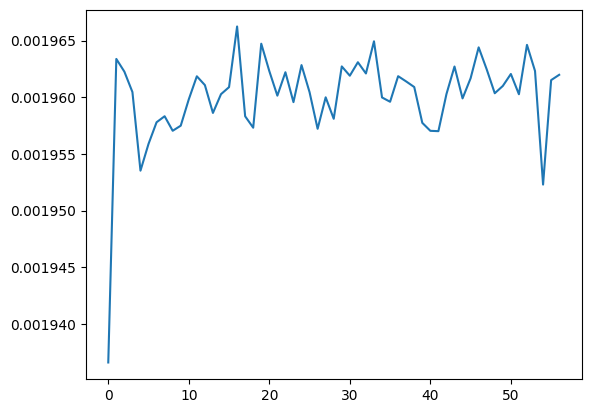

In [13]:
import numpy as np
def avg(avg, val):
    momentum = 0.99
    return avg * momentum + val * (1 - momentum)

a = np.loadtxt('results/2022-07-23/13-28-58/loss.txt')

avgs = []
for i, val in enumerate(a):
    if i == 0:
        avgs.append(val)
    avgs.append(avg(avgs[-1], val))


import matplotlib.pyplot as plt

# plt.plot(a)
plt.plot(avgs[::1000])
plt.show()


In [8]:
import numpy as np

a = np.load('results/2022-07-26/18-52-03/time.npy')

def avg(a):
    return np.mean(a, axis=0)[-1]

print(avg(a))

6.395670528437477


torch.Size([10000, 2, 3])


AssertionError: Padding length must be divisible by 2

: 